# Fruit Classification (part 2)
#### CHAPTER 08: _Visualizing Convolutional Neural Networks_
##### From **[Interpretable Machine Learning with Python](https://www.packtpub.com/product/interpretable-machine-learning-with-python/9781800203907)** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

These are all already installed on Google Colab by default so install only if running elsewhere (and ***not already installed***):

In [ ]:
!pip install --upgrade numpy pandas scikit-learn tensorflow matplotlib seaborn opencv-python scikit-image

Install these if running on Google Colab or ***not already installed***:

In [ ]:
!pip install --upgrade machine-learning-datasets
!pip install --upgrade tf-explain lime alibi shap

### Loading the Libraries

In [264]:
import math
import os
import machine_learning_datasets as mldatasets
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import cv2
from keras.utils.data_utils import get_file
#PART 2 only
from skimage.segmentation import mark_boundaries
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
import lime
from lime import lime_image
from alibi.explainers import CEM
import shap

In [59]:
print('TF version:\t\t', tf.__version__)
print('Eager exec enabled:\t', tf.executing_eagerly())

TF version:		 2.2.0
Eager exec enabled:	 False


### Understanding and Preparing the Data

In [3]:
X_train, X_test, X_val, X_val_orig, y_train, y_test, y_val, y_val_orig =\
                                    mldatasets.load("fruits-360", prepare=True)

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/fruits-360_abbrev.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter8/data/fruits-360_abbrev.zip
/Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter8/data/fruits-360_abbrev.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter8/data/fruits-360_abbrev
10633 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter8/data/fruits-360_abbrev folder


#### Data Preparation

In [6]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_val = X_val.astype('float32')/255

In [16]:
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y_train)
fruits_l = ohe.categories_[0].tolist()
print(fruits_l)

['Apple Golden', 'Apple Granny Smith', 'Apple Red', 'Avocado', 'Banana', 'Clementine', 'Grapefruit Pink', 'Mango Red', 'Nectarine', 'Onion Red', 'Onion White', 'Orange', 'Peach', 'Pear', 'Pomegranate', 'Tomato']


#### Loading the CNN Model

In [108]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)
tf.random.set_seed(rand)

In [10]:
model_path = get_file('CNN_fruits_final.hdf5',\
            'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/CNN_fruits_final.hdf5?raw=true')
cnn_fruits_mdl = keras.models.load_model(model_path)
cnn_fruits_mdl.summary()

Model: "CNN_fruits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 99, 99, 16)        208       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        2080      
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        8256      
_________________________________________________________________
maxpool2d_3 (MaxPooling2D)   (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)       3

## Assessing the CNN Classifier with Traditional Interpretation Methods

In [55]:
y_val_pred, y_val_prob =\
            mldatasets.evaluate_multiclass_mdl(cnn_fruits_mdl, X_val, y_val, fruits_l,\
                                    ohe, plot_roc=False, plot_conf_matrix=False, pct_matrix=False)

                    precision    recall  f1-score   support

      Apple Golden      0.000     0.000     0.000         4
Apple Granny Smith      0.000     0.000     0.000         4
         Apple Red      0.000     0.000     0.000         4
           Avocado      0.667     0.500     0.571         4
            Banana      0.571     1.000     0.727         4
        Clementine      0.375     0.750     0.500         4
   Grapefruit Pink      0.211     1.000     0.348         4
         Mango Red      0.500     0.250     0.333         4
         Nectarine      0.143     0.250     0.182         4
         Onion Red      0.750     0.750     0.750         4
       Onion White      1.000     0.500     0.667         4
            Orange      0.000     0.000     0.000         4
             Peach      0.000     0.000     0.000         4
              Pear      0.000     0.000     0.000         4
       Pomegranate      0.000     0.000     0.000         4
            Tomato      0.000     0.000

In [ ]:
enc = preprocessing.OrdinalEncoder()
enc.fit(y_train)
y_val_pred_exp = np.expand_dims(np.array(y_val_pred),axis=1)
y_val_pred_enc = enc.transform(y_val_pred_exp)

### Determining what Misclassifications to Focus On

In [56]:
preds_df = pd.DataFrame({'y_true':y_val[:,0], 'y_pred':y_val_pred})

probs_df = pd.DataFrame(y_val_prob*100).round(1)
probs_df.loc['Total']= probs_df.sum().round(1)
probs_df.columns = fruits_l
probs_df = probs_df.sort_values('Total', axis=1, ascending=False)
probs_df.drop(['Total'], axis=0, inplace=True)

In [25]:
avocado_FN_idxs = preds_df[(preds_df['y_true'] != preds_df['y_pred']) &\
                           (preds_df['y_true'] == 'Avocado')].index.to_list()
avocado_TP_idxs = preds_df[(preds_df['y_true'] == preds_df['y_pred']) &\
                           (preds_df['y_true'] == 'Avocado')].index.to_list()
grapefruit_FP_idxs = preds_df[(preds_df['y_true'] != preds_df['y_pred']) &\
                              (preds_df['y_pred'] == 'Grapefruit Pink')].index.to_list()
grapefruit_TP_idxs = preds_df[(preds_df['y_true'] == preds_df['y_pred']) &\
                              (preds_df['y_pred'] == 'Grapefruit Pink')].index.to_list()

## Understanding Classifications with Perturbation-Based Attribution Methods

In [39]:
idxs = avocado_TP_idxs + grapefruit_TP_idxs
X_tp = X_val[idxs]
print(X_tp.shape)

(6, 100, 100, 3)


In [40]:
labels_l = y_val_pred_enc[idxs].squeeze().\
                                    astype(int).tolist()
print(labels_l)

[3, 3, 6, 6, 6, 6]


### Occlusion Sensitivity

In [41]:
explainer = OcclusionSensitivity()

os_maps = []
for i in range(len(labels_l)):
    img = ([X_tp[i]], None)
    label = labels_l[i]
    os_map = explainer.explain(img, cnn_fruits_mdl,\
                               label, 5)
    os_maps.append(os_map)

In [307]:
explainer = OcclusionSensitivity()

os_maps = []
for i in range(len(labels_l)):
    img = ([X_tp[i]], None)
    label = labels_l[i]
    os_map = explainer.explain(img, cnn_fruits_mdl,\
                               label, 3)
    os_maps.append(os_map)

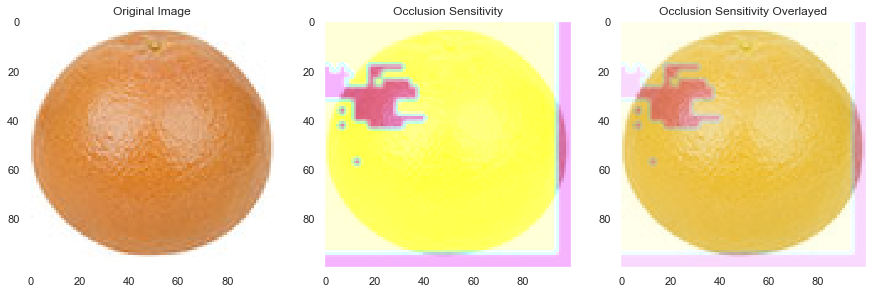

In [310]:
plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(X_tp[2])
plt.grid(b=None)
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(os_maps[2])
plt.grid(b=None)
plt.title("Occlusion Sensitivity")
plt.subplot(1, 3, 3)
plt.imshow(X_tp[2])
plt.imshow(os_maps[2], alpha=0.5)
plt.grid(b=None)
plt.title("Occlusion Sensitivity Overlayed")
plt.show()

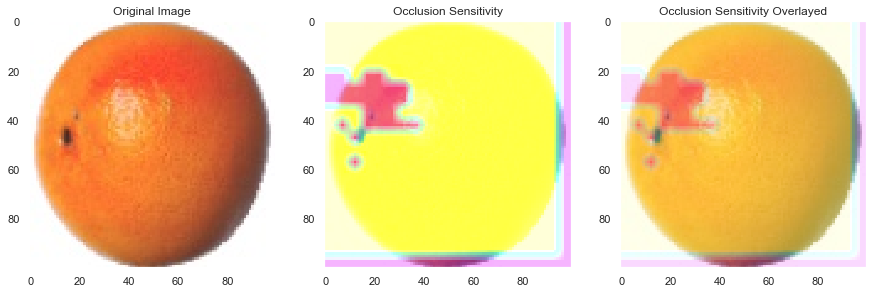

In [318]:
idx = np.random.choice(np.where(y_train[:,0] == 'Grapefruit Pink')[0], 1)[0]
os_map_train = explainer.explain(([X_train[idx]], None), cnn_fruits_mdl, label, 5)
plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(X_train[idx])
plt.grid(b=None)
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(os_map_train)
plt.grid(b=None)
plt.title("Occlusion Sensitivity")
plt.subplot(1, 3, 3)
plt.imshow(X_train[idx])
plt.imshow(os_map_train, alpha=0.5)
plt.grid(b=None)
plt.title("Occlusion Sensitivity Overlayed")
plt.show()

### LIME’s ImageExplainer

#### Initialize and Create Explanations

In [51]:
explainer = lime_image.LimeImageExplainer()

lime_expl = []
for i in range(len(labels_l)):
    explanation = explainer.\
                    explain_instance(X_tp[i].astype('double'),\
                            cnn_fruits_mdl.predict, top_labels=5,\
                            hide_color=0, num_samples=1000)
    lime_expl.append(explanation)

#### Extracting Image and Mask from Explanation

In [52]:
#Explanation with irrelevant segments hidden
img_hide, mask_hide = lime_expl[2].\
                        get_image_and_mask(lime_expl[2].top_labels[0],\
                                    positive_only=True, num_features=10,\
                                    hide_rest=True)
img_hide = mark_boundaries(img_hide / 2 + 0.5, mask_hide)

#Explanation with all segments marked for positive/negative prediction
img_show, mask_show = lime_expl[2].\
                            get_image_and_mask(lime_expl[2].top_labels[0],\
                                positive_only=False, num_features=10)
img_show = mark_boundaries(img_show / 2 + 0.5, mask_show)

#Heatmap explanation by segment
dict_heatmap = dict(lime_expl[2].local_exp[lime_expl[2].top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(lime_expl[2].segments) 

#### Plotting Explanations

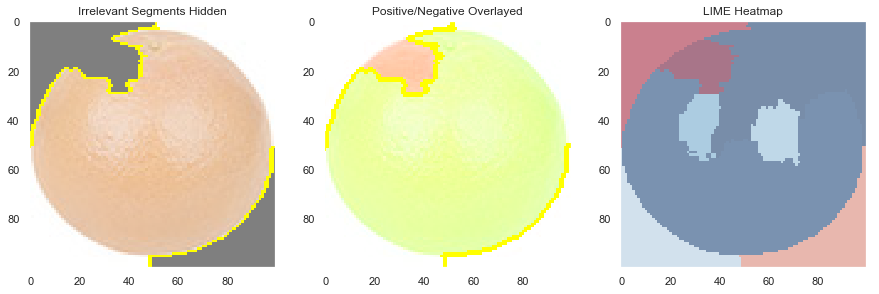

In [239]:
plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img_hide)
plt.grid(b=None)
plt.title("Irrelevant Segments Hidden")
plt.subplot(1, 3, 2)
plt.imshow(img_show)
plt.grid(b=None)
plt.title("Positive/Negative Overlayed")
plt.subplot(1, 3, 3)
plt.imshow(heatmap, alpha=0.5, cmap='RdBu')
plt.grid(b=None)
plt.title("LIME Heatmap")
plt.show()

## CEM

### Train Autoencoder

In [149]:
input_layer = tf.keras.layers.Input(shape=(100, 100, 3))
encoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',\
                                 padding='same')(input_layer)
encoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',\
                                 padding='same')(encoder)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)
bottleneck = tf.keras.layers.Conv2D(1, (3, 3), activation=None,\
                                    padding='same')(encoder)
decoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',\
                                 padding='same')(bottleneck)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',\
                                 padding='same')(decoder)
output_layer = tf.keras.layers.Conv2D(3, (3, 3), activation=None,\
                                      padding='same')(decoder)
autoencoder_mdl = tf.keras.Model(input_layer, output_layer)
autoencoder_mdl.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 100, 100, 16)      2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 50, 1)         145       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 16)        160       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 100, 100, 16)      0  

In [150]:
autoencoder_mdl.compile(loss='mse', optimizer='adam')
autoencoder_history = autoencoder_mdl.fit(X_train, X_train, epochs=5,\
                        batch_size=32, validation_data=(X_test, X_test),\
                        verbose=1)

Train on 7872 samples, validate on 2633 samples
Epoch 1/5
7872/7872 [==============================] - 116s 15ms/sample - loss: 0.0235 - val_loss: 0.0062
Epoch 2/5
7872/7872 [==============================] - 104s 13ms/sample - loss: 0.0057 - val_loss: 0.0053
Epoch 3/5
7872/7872 [==============================] - 102s 13ms/sample - loss: 0.0051 - val_loss: 0.0049
Epoch 4/5
7872/7872 [==============================] - 105s 13ms/sample - loss: 0.0047 - val_loss: 0.0045
Epoch 5/5
7872/7872 [==============================] - 101s 13ms/sample - loss: 0.0044 - val_loss: 0.0042


### Assess Autoencoder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


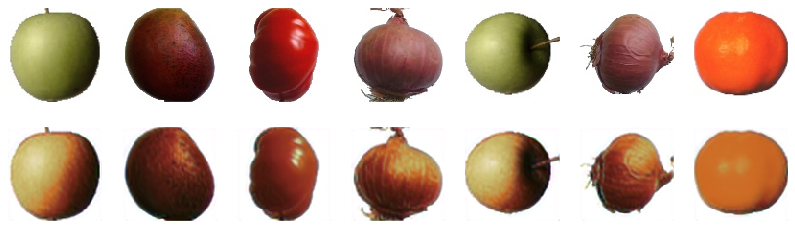

In [170]:
n = 7
rand_idxs = np.random.choice([*range(len(y_test))], n)

decoded_imgs = autoencoder_mdl.predict(X_test[rand_idxs])

plt.figure(figsize=(14, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[rand_idxs[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Fit CEM Explainers

In [176]:
cem_pn = CEM(cnn_fruits_mdl, 'PN', (1,) + X_train.shape[1:],\
             feature_range=(0.0, 1.0), max_iterations=100,\
             ae_model=autoencoder_mdl, gamma=100, c_init=1.)
cem_pn.fit(X_train, no_info_type='median')

cem_pp = CEM(cnn_fruits_mdl, 'PP', (1,) + X_train.shape[1:],\
             feature_range=(0.0, 1.0), max_iterations=100,\
             ae_model=autoencoder_mdl, gamma=100, c_init=0.5,\
             beta=0.1)
cem_pp.fit(X_train, no_info_type='median')

CEM(meta={
    'name': 'CEM',
    'type': ['blackbox', 'tensorflow', 'keras'],
    'explanations': ['local'],
    'params': {
        'mode': 'PP',
        'shape': (1, 100, 100, 3),
        'kappa': 0.0,
        'beta': 0.1,
        'feature_range': (0.0, 1.0),
        'gamma': 100,
        'learning_rate_init': 0.01,
        'max_iterations': 100,
        'c_init': 0.5,
        'c_steps': 10,
        'eps': (0.001, 0.001),
        'clip': (-100.0, 100.0),
        'update_num_grad': 1,
        'no_info_val': None,
        'write_dir': None,
        'is_model': True,
        'is_model_keras': False,
        'is_ae': True,
        'is_ae_keras': False,
        'no_info_type': 'median'
    }
})

### Extract CEM Explanations

In [ ]:
cem_pn_preds = []
cem_pn_imgs = []
cem_pp_preds = []
cem_pp_imgs = []

for i in range(len(labels_l)):
    pn_explanation = cem_pn.explain(np.array([X_tp[i]]))
    if pn_explanation.PN_pred is not None:
        cem_pn_preds.append(fruits_l[pn_explanation.PN_pred])
        cem_pn_imgs.append(pn_explanation.PN[0])
    else:
        cem_pn_preds.append("")
        cem_pn_imgs.append(np.ones(X_train.shape[1:4]))
    
    pp_explanation = cem_pp.explain(np.array([X_tp[i]]))
    if pp_explanation.PP_pred is not None:
        cem_pp_preds.append(fruits_l[pp_explanation.PP_pred])
        norm_img = (pp_explanation.PP[0] - pp_explanation.PP[0].min()) /\
                (pp_explanation.PP[0].max() - pp_explanation.PP[0].min())
        cem_pp_imgs.append(norm_img)
    else:
        cem_pp_preds.append("")
        cem_pp_imgs.append(np.ones(X_train.shape[1:4]))

### Visualize Explanations

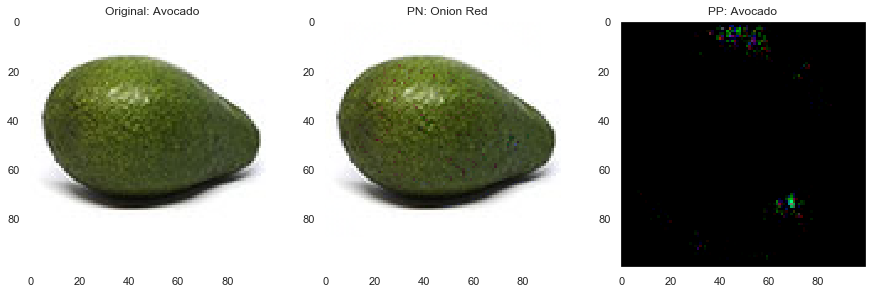

In [320]:
plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(X_tp[0])
plt.grid(b=None)
plt.title('Original: '+fruits_l[labels_l[0]])
plt.subplot(1, 3, 2)
plt.imshow(cem_pn_imgs[0])
plt.grid(b=None)
plt.title('PN: '+cem_pn_preds[0])
plt.subplot(1, 3, 3)
plt.imshow(cem_pp_imgs[0])
plt.grid(b=None)
plt.title('PP: '+cem_pp_preds[0])
plt.show()

In [295]:
np.set_printoptions(precision=3, suppress=True)

pp_pred = cnn_fruits_mdl.predict(np.array([cem_pn_imgs[0]]))[0]
print('PP Probs:\t%s' % pp_pred)
print('PP Pred:\t%s' % fruits_l[pp_pred.argmax()])

pn_pred = cnn_fruits_mdl.predict(np.array([cem_pp_imgs[0]]))[0]
print('PN Probs:\t%s' % pn_pred)
print('PN Pred:\t%s' % fruits_l[pn_pred.argmax()])

PP Probs:	[0.    0.    0.    0.155 0.    0.    0.    0.    0.    0.845 0.    0.
 0.    0.    0.    0.   ]
PP Pred:	Onion Red
PN Probs:	[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PN Pred:	Avocado


### Tying it All Together

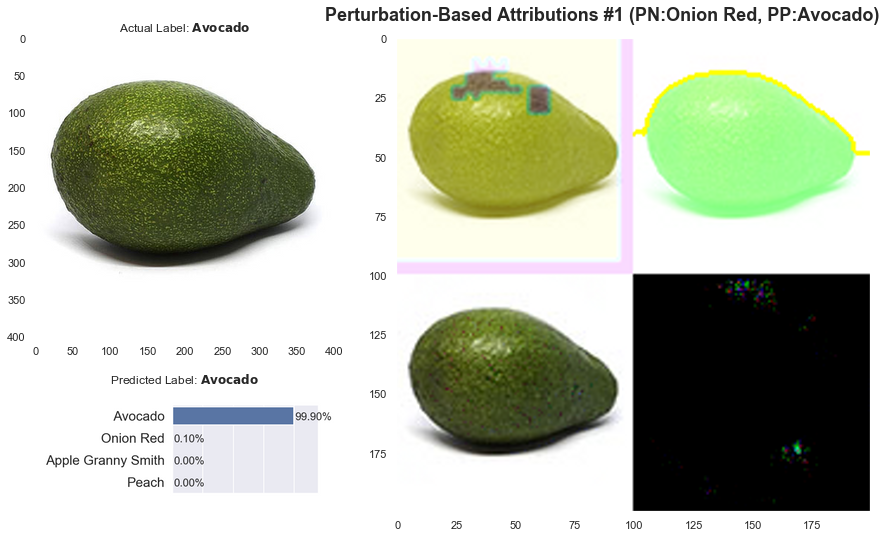

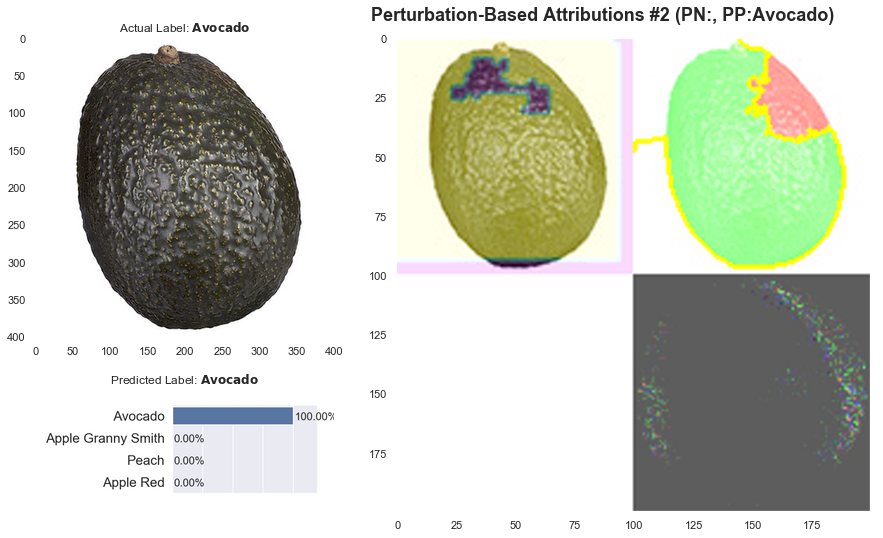

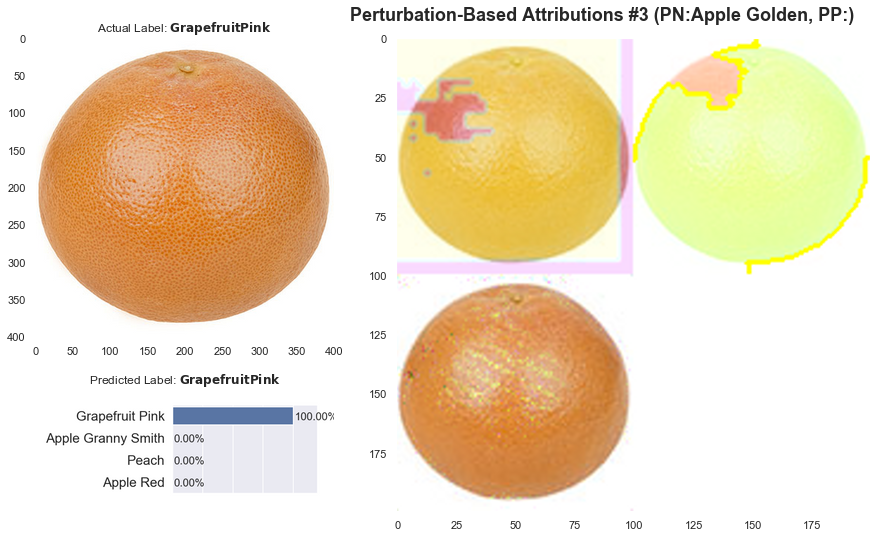

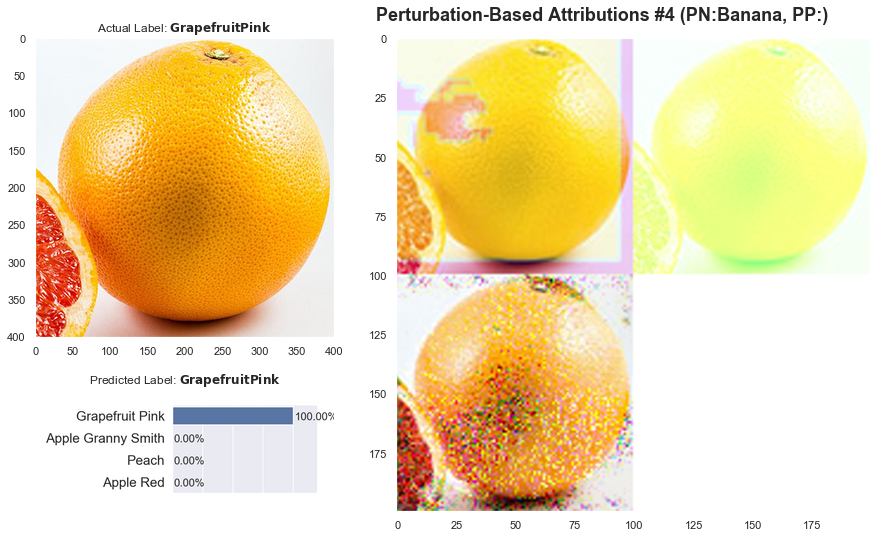

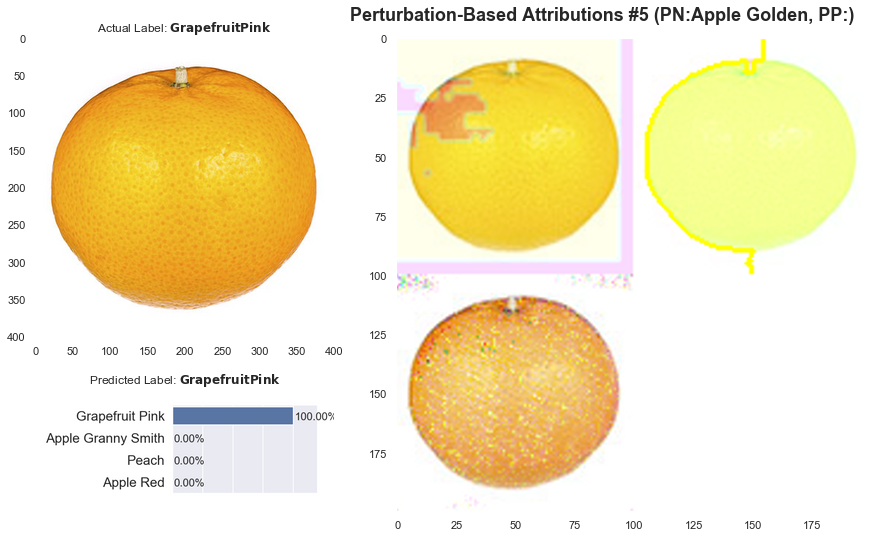

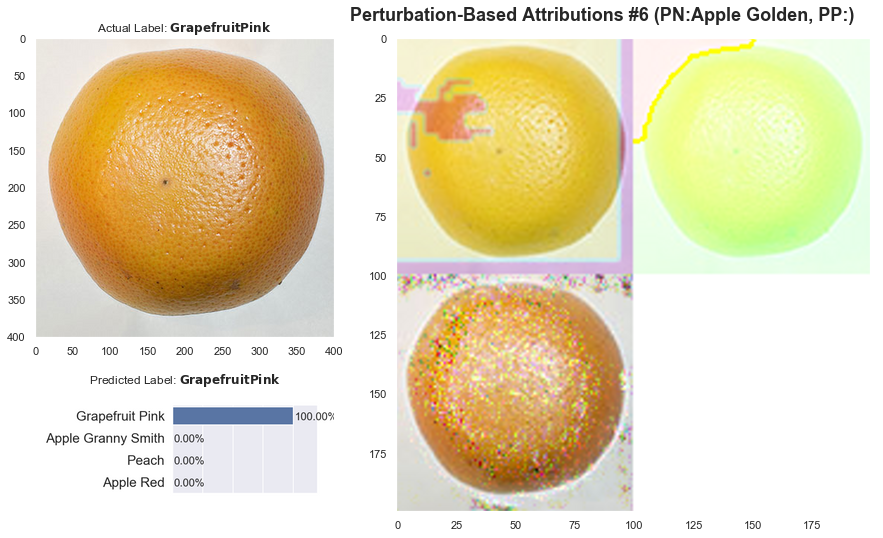

In [309]:
for pos, idx in zip([*range(len(idxs))], idxs):
    orig_img = X_val_orig[idx]
    map1 = mldatasets.heatmap_overlay(X_tp[pos], os_maps[pos]/255)
    img_show, mask_show = lime_expl[pos].\
                                get_image_and_mask(lime_expl[pos].top_labels[0],\
                                    positive_only=False, num_features=10)
    map2 = np.uint8(mark_boundaries(img_show / 2 + 0.5, mask_show)[..., :3] * 255)
    map3 = np.uint8(cem_pn_imgs[pos][..., :3] * 255)
    map4 = np.uint8(cem_pp_imgs[pos][..., :3] * 255)
    viz_img = cv2.vconcat([
            cv2.hconcat([map1, map2]),
            cv2.hconcat([map3, map4])
        ])
    y_true = y_val[idx,0]
    y_pred = y_val_pred[idx]
    probs_s = probs_df.loc[idx]
    title = 'Perturbation-Based Attributions #{} (PN:{}, PP:{})'.format(pos+1,\
                                    cem_pn_preds[pos], cem_pp_preds[pos])
    mldatasets.compare_img_pred_viz(orig_img, viz_img, y_true,\
                                    y_pred, probs_s, title=title)

### Bonus Method: SHAP’s DeepExplainer

In [259]:
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
print(background.shape)

(100, 100, 100, 3)


In [260]:
explainer = shap.DeepExplainer(cnn_fruits_mdl, background)
shap_values = explainer.shap_values(X_tp)

keras is no longer supported, please use tf.keras instead.


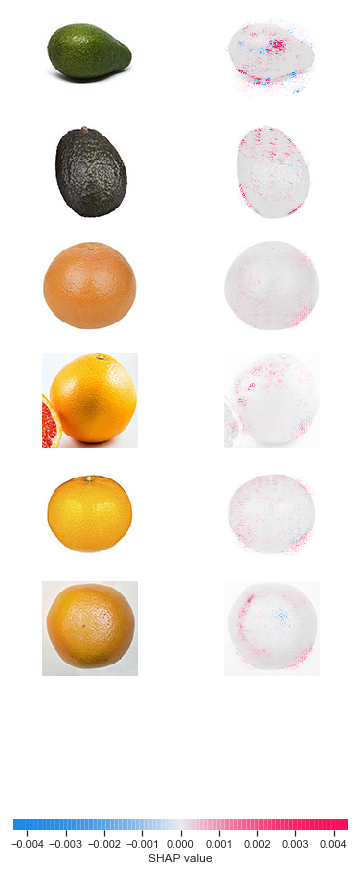

In [662]:
shap.image_plot(shap_values[3] + shap_values[6], X_tp)

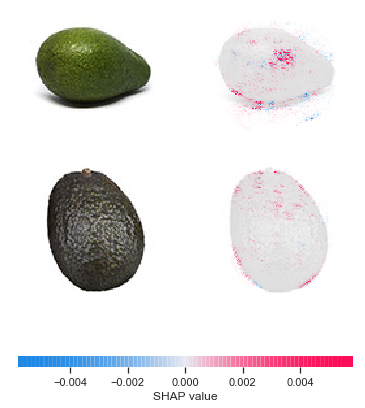

In [263]:
samp_idx = [0,1]
samp_shap_values = [s[samp_idx] for s in shap_values]
shap.image_plot(samp_shap_values[3], X_tp[samp_idx])